In [1]:
# Setting up the libraries needed

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV, train_test_split

## Reading and Exploring the Data

First, we are going to read the data and then we are going to try to understand its variables and statistics belong it.

In [2]:
# Reading the data

df = pd.read_csv("/kaggle/input/home-data-for-ml-course/train.csv")

pd.set_option("display.max_columns", 999)

In [3]:
print(f"Our data has {df.shape[0]} rows and {df.shape[1]} columns\nAnd the first 5 rows is looking like this:")
df.head()

Our data has 1460 rows and 81 columns
And the first 5 rows is looking like this:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df.isnull().sum().sort_values(ascending=False).head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
Id                 0
dtype: int64

As we can see, there are many missing values in our dataset.

The important things to notice here are:

- Variables such as *PoolQC*, *MiscFeature*, *Alley*, etc., are **nominal variables**.  
  The missing values in these columns indicate the *absence* of that particular feature in the house.

- Another important point is that for the *Garage*-related variables, all of them are missing at the same count.  
  This means that these houses **do not have a garage**, which explains why those values are missing.

## Identifying Variable Types

In [5]:
class HouseRules(BaseEstimator, TransformerMixin):
    
    """

    This class handles special domain-specific imputation and feature cleaning rules,
    including:
      - Filling categorical features that indicate absence (e.g., PoolQC, Fence, Alley)
        with "None".
      - Setting numerical features (e.g., Basement or Garage areas) to 0 when the
        corresponding categorical indicators show that the feature is absent.
      - Filling missing 'LotFrontage' values using the median of each Neighborhood
        (learned during fit). If the Neighborhood is unseen, the global median is used.
      - Converting 'MSSubClass' to a string so it is treated as a nominal categorical
        variable instead of numeric.

    The learned medians are stored during `fit()` and applied consistently during
    `transform()`, ensuring no data leakage between training and validation/test sets.
    """

    
    def __init__(self):
        self.nb_lf_med_ = None
        self.lf_med_ = None
        self.none_cats = [
            "PoolQC","MiscFeature","Alley","Fence","FireplaceQu",
            "GarageType","GarageFinish","GarageQual","GarageCond",
            "BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2",
            "MasVnrType"
        ]
        self.bsmt_nums = ["BsmtFinSF1","BsmtFinSF2","BsmtUnfSF",
                          "TotalBsmtSF","BsmtFullBath","BsmtHalfBath"]

    def fit(self, X, y=None):
        X = X.copy()
        if {"Neighborhood","LotFrontage"}.issubset(X.columns):
            self.nb_lf_med_ = X.groupby("Neighborhood")["LotFrontage"].median()
            self.lf_med_ = X["LotFrontage"].median()
        return self

    def transform(self, X):
        X = X.copy()

        # MSSubClass: kod -> nominal metin
        if "MSSubClass" in X.columns:
            X["MSSubClass"] = X["MSSubClass"].astype(str)

        # Var/yok kategorikler → "None"
        for c in self.none_cats:
            if c in X.columns:
                X[c] = X[c].fillna("None")

        # Garaj yoksa sayılsallar 0
        if "GarageQual" in X.columns:
            for c in ["GarageYrBlt","GarageCars","GarageArea"]:
                if c in X.columns:
                    X.loc[X["GarageQual"]=="None", c] = 0

        # MasVnrType None ise alan 0
        if {"MasVnrType","MasVnrArea"}.issubset(X.columns):
            X.loc[X["MasVnrType"]=="None", "MasVnrArea"] = 0

        # Bodrum yoksa bodrum sayılsallar 0
        need = {"BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2"}
        if need.issubset(X.columns):
            mask = (X["BsmtQual"]=="None") & (X["BsmtCond"]=="None") & \
                   (X["BsmtExposure"]=="None") & (X["BsmtFinType1"]=="None") & \
                   (X["BsmtFinType2"]=="None")
            for c in self.bsmt_nums:
                if c in X.columns:
                    X.loc[mask, c] = 0

        # LotFrontage mahalle medyanı
        if self.nb_lf_med_ is not None and {"Neighborhood","LotFrontage"}.issubset(X.columns):
            X["LotFrontage"] = X["LotFrontage"].fillna(X["Neighborhood"].map(self.nb_lf_med_))
            X["LotFrontage"] = X["LotFrontage"].fillna(self.lf_med_)

        return X


In [6]:
ORDINAL_ORDER = {
    "ExterQual": ["Po","Fa","TA","Gd","Ex"],
    "ExterCond": ["Po","Fa","TA","Gd","Ex"],
    "HeatingQC": ["Po","Fa","TA","Gd","Ex"],
    "KitchenQual": ["Po","Fa","TA","Gd","Ex"],
    "FireplaceQu": ["None","Po","Fa","TA","Gd","Ex"],
    "GarageQual": ["None","Po","Fa","TA","Gd","Ex"],
    "GarageCond": ["None","Po","Fa","TA","Gd","Ex"],
    "PoolQC": ["None","Fa","TA","Gd","Ex"],
    "BsmtQual": ["None","Po","Fa","TA","Gd","Ex"],
    "BsmtCond": ["None","Po","Fa","TA","Gd","Ex"],
    "BsmtExposure": ["None","No","Mn","Av","Gd"],
    "BsmtFinType1": ["None","Unf","LwQ","Rec","BLQ","ALQ","GLQ"],
    "BsmtFinType2": ["None","Unf","LwQ","Rec","BLQ","ALQ","GLQ"],
    "GarageFinish": ["None","Unf","RFn","Fin"],
    "PavedDrive": ["N","P","Y"],
    "LotShape": ["IR3","IR2","IR1","Reg"],
    "LandSlope": ["Sev","Mod","Gtl"],
    "Functional": ["Sal","Sev","Maj2","Maj1","Mod","Min2","Min1","Typ"],
    "Utilities": ["ELO","NoSeWa","NoSewr","AllPub"],
    "Fence": ["None","MnWw","GdWo","MnPrv","GdPrv"],
    "OverallQual": list(range(1,11)),   # 1..10
    "OverallCond": list(range(1,11))
}

X = df.drop(["Id", "SalePrice"], axis=1)
y = df["SalePrice"]

ordinal_cols = [c for c in ORDINAL_ORDER if c in X.columns]
nominal_cols = [c for c in X.select_dtypes(include="object").columns if c not in ordinal_cols]

real_numeric = [c for c in X.select_dtypes(include=["int64","float64"]).columns
                if c not in ["OverallQual","OverallCond"]]

In [7]:
# Let's see how our nominal variables are looking like

df[nominal_cols]

,MSZoning,Street,Alley,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,Electrical,GarageType,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Lvl,Inside,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,SBrkr,Attchd,NaN,WD,Normal
1,RL,Pave,NaN,Lvl,FR2,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,NaN,CBlock,GasA,Y,SBrkr,Attchd,NaN,WD,Normal
2,RL,Pave,NaN,Lvl,Inside,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,SBrkr,Attchd,NaN,WD,Normal
3,RL,Pave,NaN,Lvl,Corner,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,NaN,BrkTil,GasA,Y,SBrkr,Detchd,NaN,WD,Abnorml
4,RL,Pave,NaN,Lvl,FR2,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,SBrkr,Attchd,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,NaN,Lvl,Inside,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,NaN,PConc,GasA,Y,SBrkr,Attchd,NaN,WD,Normal
1456,RL,Pave,NaN,Lvl,Inside,NWAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,Plywood,Plywood,Stone,CBlock,GasA,Y,SBrkr,Attchd,NaN,WD,Normal
1457,RL,Pave,NaN,Lvl,Inside,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,CemntBd,CmentBd,NaN,Stone,GasA,Y,SBrkr,Attchd,Shed,WD,Normal
1458,RL,Pave,NaN,Lvl,Inside,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,MetalSd,MetalSd,NaN,CBlock,GasA,Y,FuseA,Attchd,NaN,WD,Normal


## Defining Features and Prediction Target for Our Model

In [8]:
# Making the train-validation split.
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size = 0.8)

In [9]:
X_train.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
294,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1953,1953,Hip,CompShg,HdBoard,HdBoard,Stone,238.0,TA,TA,CBlock,TA,TA,No,GLQ,1285,Unf,0,131,1416,GasA,TA,Y,SBrkr,1644,0,0,1644,1,0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1953.0,Fin,2,418,TA,TA,Y,110,0,0,0,0,0,NaN,NaN,NaN,0,10,2009,WD,Normal
1225,80,RL,65.0,10482,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,SLvl,6,8,1958,1958,Hip,CompShg,VinylSd,VinylSd,BrkFace,63.0,TA,Gd,CBlock,TA,TA,Av,GLQ,507,Unf,0,81,588,GasA,Ex,Y,SBrkr,1138,0,0,1138,0,1,1,0,3,1,TA,6,Typ,0,NaN,Attchd,1958.0,RFn,1,264,TA,TA,Y,224,0,0,0,0,0,NaN,MnWw,NaN,0,6,2007,WD,Normal
95,60,RL,NaN,9765,Pave,NaN,IR2,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,8,1993,1993,Gable,CompShg,VinylSd,VinylSd,BrkFace,68.0,Ex,Gd,PConc,Gd,Gd,No,ALQ,310,Unf,0,370,680,GasA,Gd,Y,SBrkr,680,790,0,1470,0,0,2,1,3,1,TA,6,Typ,1,TA,BuiltIn,1993.0,Fin,2,420,TA,TA,Y,232,63,0,0,0,0,NaN,NaN,Shed,480,4,2009,WD,Normal
352,50,RL,60.0,9084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Artery,Norm,1Fam,1.5Fin,5,6,1941,1950,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,Fa,Mn,LwQ,236,Rec,380,0,616,GasA,TA,N,SBrkr,616,495,0,1111,0,1,1,0,3,1,TA,5,Typ,0,NaN,Detchd,1941.0,Unf,1,200,TA,Fa,Y,48,0,0,0,0,0,NaN,NaN,NaN,0,3,2008,ConLw,Normal
1212,30,RL,50.0,9340,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,4,6,1941,1950,Hip,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,344,Unf,0,328,672,GasA,TA,Y,SBrkr,672,0,0,672,1,0,1,0,2,1,TA,4,Typ,0,NaN,Attchd,1941.0,Unf,1,234,TA,TA,N,0,113,0,0,0,0,NaN,NaN,NaN,0,8,2009,WD,Normal


In [10]:
# Train data's missing values
X_train.isnull().sum().sort_values(ascending = False).head(6)

PoolQC         1164
MiscFeature    1123
Alley          1096
Fence           937
MasVnrType      693
FireplaceQu     538
dtype: int64

In [11]:
# Our nominal cols in training data is looking like this

X_train[nominal_cols]

,MSZoning,Street,Alley,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,Electrical,GarageType,MiscFeature,SaleType,SaleCondition
294,RL,Pave,NaN,Lvl,Inside,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,HdBoard,HdBoard,Stone,CBlock,GasA,Y,SBrkr,Attchd,NaN,WD,Normal
1225,RL,Pave,NaN,Lvl,Inside,NAmes,Norm,Norm,1Fam,SLvl,Hip,CompShg,VinylSd,VinylSd,BrkFace,CBlock,GasA,Y,SBrkr,Attchd,NaN,WD,Normal
95,RL,Pave,NaN,Lvl,Corner,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,SBrkr,BuiltIn,Shed,WD,Normal
352,RL,Pave,NaN,Lvl,Inside,Edwards,Artery,Norm,1Fam,1.5Fin,Gable,CompShg,VinylSd,VinylSd,NaN,CBlock,GasA,N,SBrkr,Detchd,NaN,ConLw,Normal
1212,RL,Pave,NaN,Lvl,Inside,Edwards,Norm,Norm,1Fam,1Story,Hip,CompShg,MetalSd,MetalSd,NaN,CBlock,GasA,Y,SBrkr,Attchd,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
972,RL,Pave,NaN,Lvl,Inside,SawyerW,Norm,Norm,TwnhsE,1Story,Gable,CompShg,Plywood,Plywood,NaN,CBlock,GasA,Y,SBrkr,Attchd,NaN,WD,Normal
1217,FV,Pave,NaN,Lvl,Inside,Somerst,Norm,Norm,1Fam,1Story,Gable,CompShg,CemntBd,CmentBd,Stone,PConc,GasA,Y,SBrkr,Attchd,NaN,New,Partial
330,RL,Pave,NaN,Lvl,Inside,NAmes,Norm,Norm,Duplex,1Story,Gable,CompShg,HdBoard,HdBoard,BrkFace,CBlock,GasA,Y,SBrkr,Detchd,NaN,WD,Normal
1123,RL,Pave,NaN,Lvl,Inside,Edwards,Norm,Norm,1Fam,1Story,Hip,CompShg,VinylSd,VinylSd,NaN,CBlock,GasA,Y,SBrkr,NaN,NaN,WD,Normal


## Identifying Skewed Variables for Log Transformation

Log transformation is a way to change data that has very large numbers, very small numbers or a skewed shape. It works by taking the logarithm of each number in the data which helps to “compress” the large values and spread out the small ones.

In [12]:
# Creating a temporary data to keep the train data same for future use.
X_train_tmp = X_train[real_numeric].copy()


# NA values must be filled because log transformation only accept non-na values . So lets use the median of our columns to fill them. (training data)
for col in X_train_tmp.columns:
    X_train_tmp[col] = X_train_tmp[col].fillna(X_train_tmp[col].median())

# Defining skewed variables
skewed_features = X_train_tmp.apply(lambda x: x.skew()).sort_values(ascending=False)
print(f"These are the skewed features and their skew value from our data:\n{skewed_features}\n")
high_skewed = skewed_features[skewed_features > 1].index.tolist()

num_cols_for_log = high_skewed
num_cols_no_log = [c for c in real_numeric if c not in num_cols_for_log]
print(f"{num_cols_for_log}\n\nThese columns skews are higher than 1\nWhich means these are highly right skewed, we are going to apply log transformation to them")

These are the skewed features and their skew value from our data:
MiscVal          17.805915
PoolArea         17.405532
LotArea          12.709237
3SsnPorch         9.305768
LowQualFinSF      8.633969
KitchenAbvGr      4.229243
ScreenPorch       4.136209
BsmtFinSF2        4.076571
BsmtHalfBath      4.005786
EnclosedPorch     3.024939
LotFrontage       2.704329
MasVnrArea        2.688615
OpenPorchSF       2.469189
BsmtFinSF1        1.898027
TotalBsmtSF       1.673813
1stFlrSF          1.506878
WoodDeckSF        1.442218
MSSubClass        1.438503
GrLivArea         1.381437
BsmtUnfSF         0.928468
2ndFlrSF          0.776627
TotRmsAbvGrd      0.719547
HalfBath          0.673827
Fireplaces        0.638265
BsmtFullBath      0.548579
BedroomAbvGr      0.337404
MoSold            0.203800
GarageArea        0.165507
YrSold            0.099745
FullBath          0.045852
GarageCars       -0.357620
YearRemodAdd     -0.495617
YearBuilt        -0.603279
GarageYrBlt      -0.653977
dtype: float64



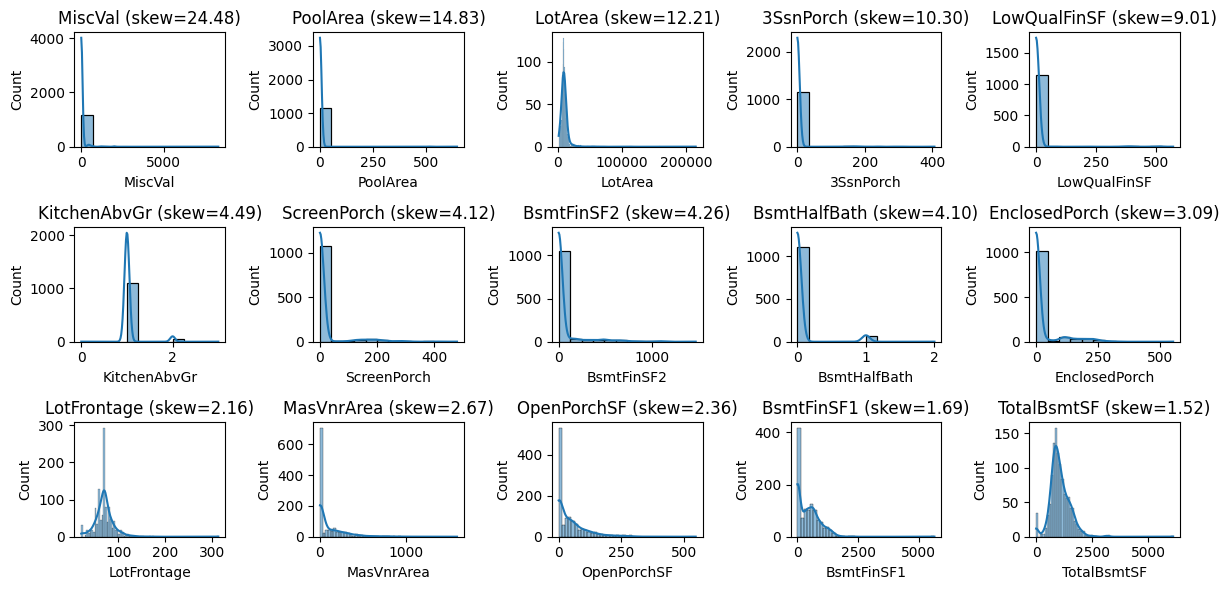

In [13]:
# Let's see how our skewed variables distributed

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)

    plt.figure(figsize=(12, 6))
    for i, col in enumerate(skewed_features[skewed_features >1].index[:15]): 
        plt.subplot(3, 5, i+1)
        sns.histplot(X_train_tmp[col], kde=True)
        plt.title(f"{col} (skew={df[col].skew():.2f})")
    plt.tight_layout()
    plt.show()

## Constructing Our Pipeline for the Model

In [14]:
# If a column is numeric and it needed to be applied log transformation
numeric_log_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")), # fill the na values with median value
    ("log", FunctionTransformer(func=np.log1p, feature_names_out="one-to-one")),
])

# If a column is numeric and wont apply log transformation
numeric_plain_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    # no log here
])

# Take the ranked orders from the ordinal order list for every ordinal column and encode it
ordinal_encoder = OrdinalEncoder(
    categories=[ORDINAL_ORDER[c] for c in ordinal_cols],
    handle_unknown = "use_encoded_value", unknown_value = -1
)

# It imputes NA values with mode value
# It encodes each category with an integer value based on its order or ranking
ordinal_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")), # fill the na values with the mode value
    ("encode", ordinal_encoder),
])


# If a column is nominal we have to apply label encoding by using OneHotEncoder
# Each row is encoded as 1 or 0 to indicate the presence or absence of a category
nominal_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encode", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])


# Clustering all of the pipelines in one column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num_log",  numeric_log_pipeline, num_cols_for_log),
        ("num_plain", numeric_plain_pipeline, num_cols_no_log),
        ("ordinal", ordinal_pipeline, ordinal_cols),
        ("nominal", nominal_pipeline, nominal_cols),
    ],
    remainder="passthrough"
)

# Defining our model
model = XGBRegressor(random_state = 0)


# Constructing the full pipeline including column transformer and the model
# Including the HouseRules class for applying all of the special applications for our variables
full_pipeline = Pipeline(steps=[
    ("rules", HouseRules()),
    ("preprocess", preprocessor),
    ("model", XGBRegressor(random_state=0, n_jobs=-1)),
])

### Lets fit our training data and target prediction to our pipeline

By doing this all of these preprocessing steps will be applied:
*  Log transformation applied to skewed features
* Numeric NA values filled with the median value
* Ordinal variables encoded with OrdinalEncoder
* Nominal variables encoded with OneHotEncoder

## Hyperparameter Tuning Using GridSearchCV


Let's use GridSearchCV to find best hyperparameters for our XGBoost model.

In [15]:
def mae_on_original(y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log)   
    y_pred = np.expm1(y_pred_log)
    return mean_absolute_error(y_true, y_pred)

mae_orig_scorer  = make_scorer(mae_on_original,  greater_is_better=False)

param_grid = {
    "model__n_estimators": [100, 500, 1000],
    "model__learning_rate": [0.05, 0.1, 0.5],
    "model__max_depth": [4, 6, 8],
    "model__subsample": [0.7, 0.9],
    "model__colsample_bytree": [0.7, 0.9],
}

grid = GridSearchCV(
    estimator = full_pipeline,
    param_grid = param_grid,
    cv = 5,
    scoring = mae_orig_scorer,
    n_jobs = -1,
    refit = True,
    verbose = 0
)

grid.fit(X_train, np.log1p(y_train))

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rules', HouseRules()),
                                       ('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_log',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('log',
                                                                                          FunctionTransformer(feature_names_out='one-to-one',
                                                                                                              func=<ufunc 'log1p'>))]),
                                                                         ['MiscVal',
                                                                          'PoolArea',
                                                                          'LotArea',
                                                                          '3SsnPorch',
                                                                          'LowQualFinSF',...
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=-1,
                                                     num_parallel_tree=None,
                                                     random_state=0, ...))]),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.7, 0.9],
                         'model__learning_rate': [0.05, 0.1, 0.5],
                         'model__max_depth': [4, 6, 8],
                         'model__n_estimators': [100, 500, 1000],
                         'model__subsample': [0.7, 0.9]},
             scoring=make_scorer(mae_on_original, greater_is_better=False))

In [16]:
# Best hyperparameters and their mean score showed.

results = pd.DataFrame(grid.cv_results_)
results[["param_model__colsample_bytree", "param_model__learning_rate", "param_model__max_depth", "param_model__n_estimators", "param_model__subsample", "mean_test_score"]]

,param_model__colsample_bytree,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,param_model__subsample,mean_test_score
0,0.7,0.05,4,100,0.7,-16571.882267
1,0.7,0.05,4,100,0.9,-16501.483838
2,0.7,0.05,4,500,0.7,-15462.579489
3,0.7,0.05,4,500,0.9,-15468.206303
4,0.7,0.05,4,1000,0.7,-15491.631598
...,...,...,...,...,...,...
103,0.9,0.5,8,100,0.9,-20294.851914
104,0.9,0.5,8,500,0.7,-21349.391165
105,0.9,0.5,8,500,0.9,-20295.362545
106,0.9,0.5,8,1000,0.7,-21349.037019


In [17]:
print(grid.best_params_)
print("\n",-grid.best_score_)

{'model__colsample_bytree': 0.9, 'model__learning_rate': 0.05, 'model__max_depth': 4, 'model__n_estimators': 500, 'model__subsample': 0.9}

 15424.61871758763


In [18]:
# Since refit=True in our GridSearchCV our best estimators has been saved and applied to our model
# Thus we are assigning it to a variable

best_pipeline = grid.best_estimator_

In [19]:
# Let's see how our train data looking like after we fitted to the pipeline
# All of the preprocess and encoding methods has been applied

feature_names = best_pipeline.named_steps["preprocess"].get_feature_names_out()
X_train_after = pd.DataFrame(
    best_pipeline.named_steps["preprocess"].transform(X_train),
    columns=feature_names,
    index=X_train.index
)

In [20]:
X_train_after

,num_log__MiscVal,num_log__PoolArea,num_log__LotArea,num_log__3SsnPorch,num_log__LowQualFinSF,num_log__KitchenAbvGr,num_log__ScreenPorch,num_log__BsmtFinSF2,num_log__BsmtHalfBath,num_log__EnclosedPorch,num_log__LotFrontage,num_log__MasVnrArea,num_log__OpenPorchSF,num_log__BsmtFinSF1,num_log__TotalBsmtSF,num_log__1stFlrSF,num_log__WoodDeckSF,num_log__MSSubClass,num_log__GrLivArea,num_plain__YearBuilt,num_plain__YearRemodAdd,num_plain__BsmtUnfSF,num_plain__2ndFlrSF,num_plain__BsmtFullBath,num_plain__FullBath,num_plain__HalfBath,num_plain__BedroomAbvGr,num_plain__TotRmsAbvGrd,num_plain__Fireplaces,num_plain__GarageYrBlt,num_plain__GarageCars,num_plain__GarageArea,num_plain__MoSold,num_plain__YrSold,ordinal__ExterQual,ordinal__ExterCond,ordinal__HeatingQC,ordinal__KitchenQual,ordinal__FireplaceQu,ordinal__GarageQual,ordinal__GarageCond,ordinal__PoolQC,ordinal__BsmtQual,ordinal__BsmtCond,ordinal__BsmtExposure,ordinal__BsmtFinType1,ordinal__BsmtFinType2,ordinal__GarageFinish,ordinal__PavedDrive,ordinal__LotShape,ordinal__LandSlope,ordinal__Functional,ordinal__Utilities,ordinal__Fence,ordinal__OverallQual,ordinal__OverallCond,nominal__MSZoning_C (all),nominal__MSZoning_FV,nominal__MSZoning_RH,nominal__MSZoning_RL,nominal__MSZoning_RM,nominal__Street_Grvl,nominal__Street_Pave,nominal__Alley_Grvl,nominal__Alley_None,nominal__Alley_Pave,nominal__LandContour_Bnk,nominal__LandContour_HLS,nominal__LandContour_Low,nominal__LandContour_Lvl,nominal__LotConfig_Corner,nominal__LotConfig_CulDSac,nominal__LotConfig_FR2,nominal__LotConfig_FR3,nominal__LotConfig_Inside,nominal__Neighborhood_Blmngtn,nominal__Neighborhood_Blueste,nominal__Neighborhood_BrDale,nominal__Neighborhood_BrkSide,nominal__Neighborhood_ClearCr,nominal__Neighborhood_CollgCr,nominal__Neighborhood_Crawfor,nominal__Neighborhood_Edwards,nominal__Neighborhood_Gilbert,nominal__Neighborhood_IDOTRR,nominal__Neighborhood_MeadowV,nominal__Neighborhood_Mitchel,nominal__Neighborhood_NAmes,nominal__Neighborhood_NPkVill,nominal__Neighborhood_NWAmes,nominal__Neighborhood_NoRidge,nominal__Neighborhood_NridgHt,nominal__Neighborhood_OldTown,nominal__Neighborhood_SWISU,nominal__Neighborhood_Sawyer,nominal__Neighborhood_SawyerW,nominal__Neighborhood_Somerst,nominal__Neighborhood_StoneBr,nominal__Neighborhood_Timber,nominal__Neighborhood_Veenker,nominal__Condition1_Artery,nominal__Condition1_Feedr,nominal__Condition1_Norm,nominal__Condition1_PosA,nominal__Condition1_PosN,nominal__Condition1_RRAe,nominal__Condition1_RRAn,nominal__Condition1_RRNe,nominal__Condition1_RRNn,nominal__Condition2_Artery,nominal__Condition2_Feedr,nominal__Condition2_Norm,nominal__Condition2_PosA,nominal__Condition2_PosN,nominal__Condition2_RRAe,nominal__Condition2_RRAn,nominal__Condition2_RRNn,nominal__BldgType_1Fam,nominal__BldgType_2fmCon,nominal__BldgType_Duplex,nominal__BldgType_Twnhs,nominal__BldgType_TwnhsE,nominal__HouseStyle_1.5Fin,nominal__HouseStyle_1.5Unf,nominal__HouseStyle_1Story,nominal__HouseStyle_2.5Fin,nominal__HouseStyle_2.5Unf,nominal__HouseStyle_2Story,nominal__HouseStyle_SFoyer,nominal__HouseStyle_SLvl,nominal__RoofStyle_Flat,nominal__RoofStyle_Gable,nominal__RoofStyle_Gambrel,nominal__RoofStyle_Hip,nominal__RoofStyle_Mansard,nominal__RoofStyle_Shed,nominal__RoofMatl_ClyTile,nominal__RoofMatl_CompShg,nominal__RoofMatl_Metal,nominal__RoofMatl_Roll,nominal__RoofMatl_Tar&Grv,nominal__RoofMatl_WdShake,nominal__RoofMatl_WdShngl,nominal__Exterior1st_AsbShng,nominal__Exterior1st_AsphShn,nominal__Exterior1st_BrkComm,nominal__Exterior1st_BrkFace,nominal__Exterior1st_CBlock,nominal__Exterior1st_CemntBd,nominal__Exterior1st_HdBoard,nominal__Exterior1st_ImStucc,nominal__Exterior1st_MetalSd,nominal__Exterior1st_Plywood,nominal__Exterior1st_Stone,nominal__Exterior1st_Stucco,nominal__Exterior1st_VinylSd,nominal__Exterior1st_Wd Sdng,nominal__Exterior1st_WdShing,nominal__Exterior2nd_AsbShng,nominal__Exterior2nd_AsphShn,nominal__Exterior2nd_Brk Cmn,nominal__Exterior2nd_BrkFace,nominal__Exterior2nd_CBlock,nominal__Exterio

## Predicting Test data

In [21]:
# Reading the test data

test_df = pd.read_csv("/kaggle/input/home-data-for-ml-course/test.csv.gz")

In [22]:
# First 5 rows of test data

test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,NaN,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [23]:
print(f"Our test data has {test_df.shape[0]} rows and {test_df.shape[1]} columns")

Our test data has 1459 rows and 80 columns


In [24]:
test_df.isnull().sum().sort_values(ascending=False)[0:20]

PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
MasVnrType       894
FireplaceQu      730
LotFrontage      227
GarageYrBlt       78
GarageQual        78
GarageFinish      78
GarageCond        78
GarageType        76
BsmtCond          45
BsmtQual          44
BsmtExposure      44
BsmtFinType1      42
BsmtFinType2      42
MasVnrArea        15
MSZoning           4
BsmtHalfBath       2
dtype: int64

In [25]:
# Predict the test data (predictions are in log scale)
y_pred_log = grid.predict(test_df)

# Applying the inverse of the log1p transformation to get predictions in the original scale
y_pred = np.expm1(y_pred_log)

In [26]:
submission = pd.DataFrame({
    "Id": test_df["Id"],
    "SalePrice": y_pred
})

submission.to_csv("submission.csv", index=False)